In [41]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

In [42]:
df = pd.read_csv('./data/sample.csv')

In [43]:
df

,action_taken_name,agency_name,applicant_ethnicity_name,applicant_race_name_1,applicant_sex_name,applicant_income_000s,co_applicant_ethnicity_name,co_applicant_race_name_1,co_applicant_sex_name,county_name,...,owner_occupancy_name,preapproval_name,property_type_name,purchaser_type_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population
0,Application denied by financial institution,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,176.0,No co-applicant,No co-applicant,No co-applicant,Chautauqua County,...,Not owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,235,2605.0,930.0,6.850000,2979.0
1,Application withdrawn by applicant,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,53.0,No co-applicant,No co-applicant,No co-applicant,Erie County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,69000.0,108,2053.0,821.0,33.580002,4416.0
2,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Male,223.0,Not Hispanic or Latino,White,Female,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,659,497.0,387.0,49.959999,1363.0
3,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,Asian,Female,43.0,No co-applicant,No co-applicant,No co-applicant,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,103,251.0,558.0,32.090000,1960.0
4,Loan originated,National Credit Union Administration,Not Hispanic or Latino,White,Male,72.0,No co-applicant,No co-applicant,No co-applicant,Steuben County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,45,1514.0,1003.0,2.120000,3391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175857,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,118.0,No co-applicant,No co-applicant,No co-applicant,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Affiliate institution,109000.0,300,1470.0,1337.0,17.110001,4448.0
175858,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Female,27.0,No co-applicant,No co-applicant,No co-applicant,Monroe County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,"Life insurance company, credit union, mortgage...",69700.0,88,1719.0,1490.0,16.040001,4658.0
175859,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,215.0,Not Hispanic or Latino,White,Female,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,Fannie Mae (FNMA),109000.0,205,1547.0,1455.0,7.730000,4671.0
175860,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,116.0,No co-applicant,No co-applicant,No co-applicant,Rockland County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Freddie Mac (FHLMC),71300.0,200,1743.0,1534.0,19.969999,5484.0


In [44]:
# Overview over null values

null_df = pd.DataFrame({'Null_Values': df.isna().sum(), 'Percentage': round((df.isna().sum())/(df.shape[0])*(100),2)}).reset_index()
null_df

,index,Null_Values,Percentage
0,action_taken_name,0,0.00
1,agency_name,0,0.00
2,applicant_ethnicity_name,0,0.00
3,applicant_race_name_1,0,0.00
4,applicant_sex_name,0,0.00
5,applicant_income_000s,24518,13.94
6,co_applicant_ethnicity_name,0,0.00
7,co_applicant_race_name_1,0,0.00
8,co_applicant_sex_name,0,0.00
9,county_name,485,0.28


In [45]:
# Drop redundand information

df = df.drop(['applicant_ethnicity_name', 'co_applicant_ethnicity_name'], axis = 1)

In [46]:
df.columns

Index(['action_taken_name', 'agency_name', 'applicant_race_name_1',
       'applicant_sex_name', 'applicant_income_000s',
       'co_applicant_race_name_1', 'co_applicant_sex_name', 'county_name',
       'denial_reason_name_1', 'denial_reason_name_2', 'denial_reason_name_3',
       'hoepa_status_name', 'lien_status_name', 'loan_purpose_name',
       'loan_type_name', 'msamd_name', 'owner_occupancy_name',
       'preapproval_name', 'property_type_name', 'purchaser_type_name',
       'hud_median_family_income', 'loan_amount_000s',
       'number_of_1_to_4_family_units', 'number_of_owner_occupied_units',
       'minority_population', 'population'],
      dtype='object')

In [47]:
df['action_taken_name'].groupby(df.action_taken_name).count()

action_taken_name
Application approved but not accepted                   5743
Application denied by financial institution            32005
Application withdrawn by applicant                     15765
File closed for incompleteness                          6682
Loan originated                                        90982
Loan purchased by the institution                      24682
Preapproval request denied by financial institution        3
Name: action_taken_name, dtype: int64

In [48]:
# Filling null values 

df.county_name = df.county_name.fillna('No information')
df.msamd_name = df.msamd_name.fillna('No information')
df.denial_reason_name_1 = df.denial_reason_name_1.fillna(0)
df.denial_reason_name_2 = df.denial_reason_name_2.fillna(0)
df.denial_reason_name_3 = df.denial_reason_name_3.fillna(0)
df.applicant_income_000s = df.applicant_income_000s.fillna(df.applicant_income_000s.mean()).astype(int)
df.hud_median_family_income = df.hud_median_family_income.fillna(df.hud_median_family_income.mean()).astype(int)
df.minority_population = df.minority_population.fillna(df.minority_population.mean())
df.number_of_1_to_4_family_units = df.number_of_1_to_4_family_units.fillna(df.number_of_1_to_4_family_units.mean()).astype(int)
df.number_of_owner_occupied_units = df.number_of_owner_occupied_units.fillna(df.number_of_owner_occupied_units.mean()).astype(int)
df.population = df.population.fillna(df.population.mean()).astype(int)

In [49]:
# Converting columns from str to int without typing them as category

# I combine the 2 status' 'Loan originated' and 'Application approved but not accepted'. 
# My understanding is that the application was approved by the lender but not accepted by the applicant.
df.action_taken_name = df.action_taken_name.map({'Application denied by financial institution': 0, 'Preapproval request denied by financial institution': 0, 'File closed for incompleteness': 1, 'Application withdrawn by applicant': 2, 'Loan purchased by the institution': 3, 'Application approved but not accepted': 4, 'Loan originated': 4})

# Converting columns manually for the same order of information with applicant and co-applicant, labelling them astype('category)

df.applicant_race_name_1 = df.applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6})
df.applicant_sex_name = df.applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3})
df.co_applicant_race_name_1 = df.co_applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6, 'No co-applicant': 7})
df.co_applicant_sex_name = df.co_applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.denial_reason_name_1 = df.denial_reason_name_1.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_2 = df.denial_reason_name_2.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_3 = df.denial_reason_name_3.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})


In [50]:
pd.DataFrame({'Null_Values': df.isna().sum()}).reset_index()

,index,Null_Values
0,action_taken_name,0
1,agency_name,0
2,applicant_race_name_1,0
3,applicant_sex_name,0
4,applicant_income_000s,0
5,co_applicant_race_name_1,0
6,co_applicant_sex_name,0
7,county_name,0
8,denial_reason_name_1,0
9,denial_reason_name_2,0


In [51]:
# Converting several columns from str to int, labelling some of them astype('category)

column_list = [1, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19]

for i in column_list:
    df.iloc[:,i] = pd.Categorical(df.iloc[:,i], ordered=True).codes
    # df.iloc[:,i] = df.iloc[:,i].astype('category')

In [52]:
df.dtypes

action_taken_name                   int64
agency_name                          int8
applicant_race_name_1               int64
applicant_sex_name                  int64
applicant_income_000s               int32
co_applicant_race_name_1            int64
co_applicant_sex_name               int64
county_name                          int8
denial_reason_name_1                int64
denial_reason_name_2                int64
denial_reason_name_3                int64
hoepa_status_name                    int8
lien_status_name                     int8
loan_purpose_name                    int8
loan_type_name                       int8
msamd_name                           int8
owner_occupancy_name                 int8
preapproval_name                     int8
property_type_name                   int8
purchaser_type_name                  int8
hud_median_family_income            int32
loan_amount_000s                    int64
number_of_1_to_4_family_units       int32
number_of_owner_occupied_units    

<AxesSubplot:>

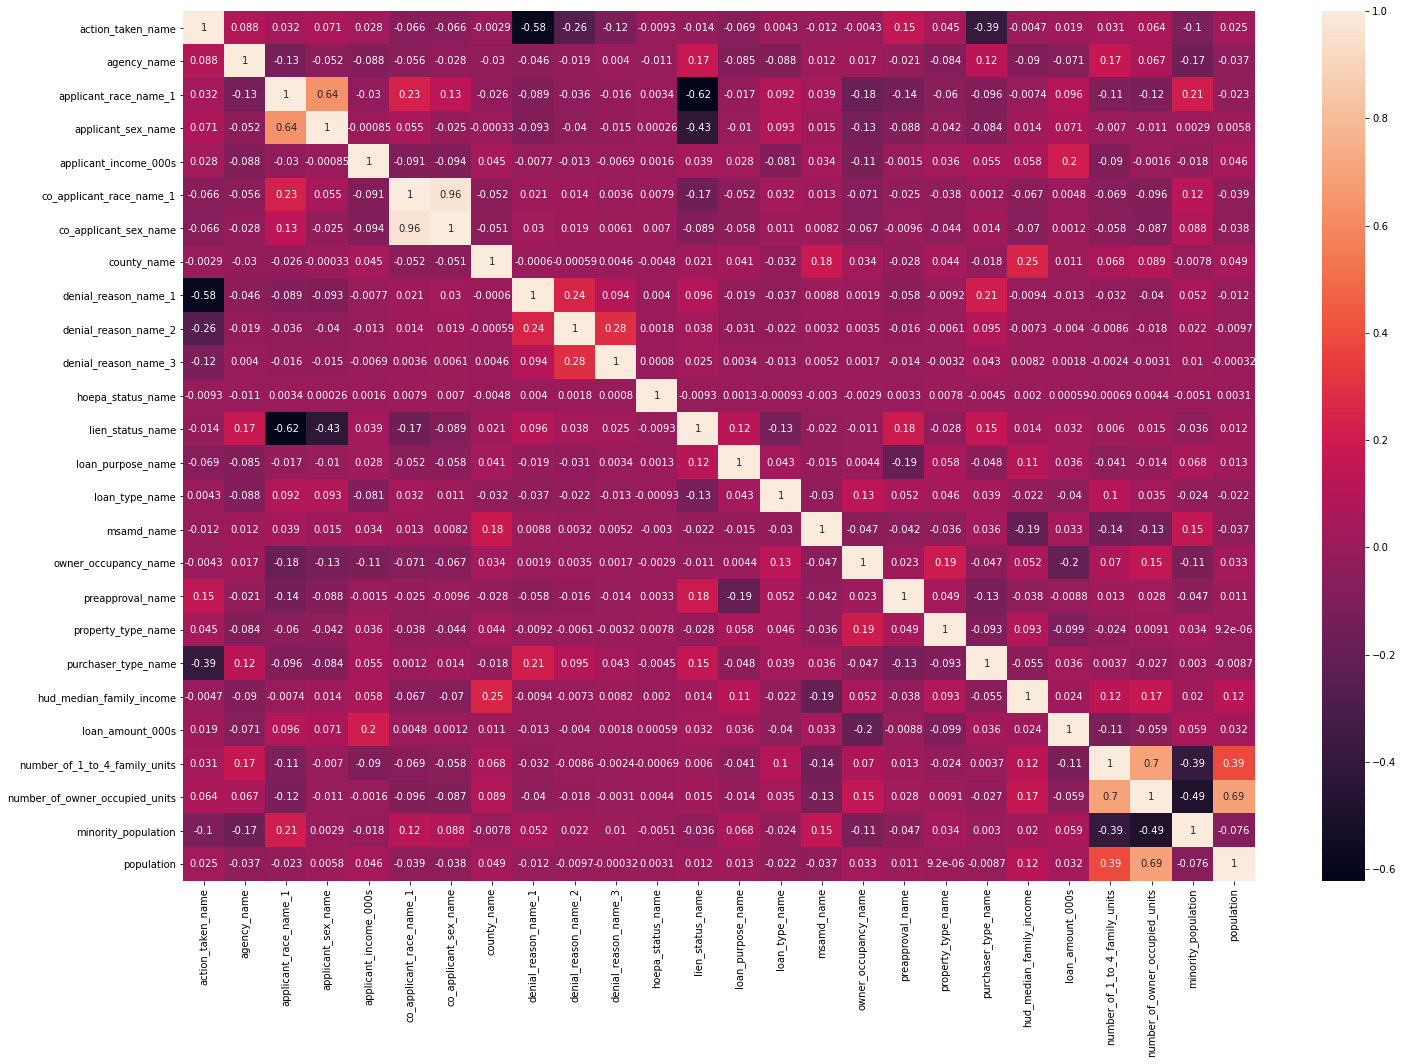

In [53]:
fig, ax = plt.subplots(figsize=(24, 16)) 
sns.heatmap(df.corr(), annot=True, ax = ax)

In [54]:
df.var()

action_taken_name                 2.403572e+00
agency_name                       2.723266e+00
applicant_race_name_1             2.909737e+00
applicant_sex_name                5.531195e-01
applicant_income_000s             6.419958e+04
co_applicant_race_name_1          8.174348e+00
co_applicant_sex_name             1.895169e+00
county_name                       2.541271e+02
denial_reason_name_1              1.814050e+00
denial_reason_name_2              4.989755e-01
denial_reason_name_3              1.107187e-01
hoepa_status_name                 1.535068e-04
lien_status_name                  5.560367e-01
loan_purpose_name                 4.161178e-01
loan_type_name                    4.669386e-01
msamd_name                        1.121180e+01
owner_occupancy_name              1.346662e-01
preapproval_name                  2.045529e-01
property_type_name                7.736994e-02
purchaser_type_name               4.646840e+00
hud_median_family_income          2.614981e+08
loan_amount_0

In [55]:
# Correlation depending on loan_approved

df.corr()['action_taken_name'].abs().sort_values(ascending = False)

action_taken_name                 1.000000
denial_reason_name_1              0.584107
purchaser_type_name               0.390909
denial_reason_name_2              0.264290
preapproval_name                  0.145690
denial_reason_name_3              0.118732
minority_population               0.103286
agency_name                       0.088276
applicant_sex_name                0.070726
loan_purpose_name                 0.069463
co_applicant_race_name_1          0.066278
co_applicant_sex_name             0.065996
number_of_owner_occupied_units    0.063871
property_type_name                0.044963
applicant_race_name_1             0.031914
number_of_1_to_4_family_units     0.031149
applicant_income_000s             0.027717
population                        0.025371
loan_amount_000s                  0.018752
lien_status_name                  0.014104
msamd_name                        0.011811
hoepa_status_name                 0.009285
hud_median_family_income          0.004720
loan_type_n

In [56]:
X = df.drop(['action_taken_name'], axis = 1)
y = df['action_taken_name']
y = np.array(y)

In [57]:
# How many denied or approved loans does the dataset contain?
# 'Application denied by financial institution': 0, 
# 'File closed for incompleteness': 1, 
# 'Application withdrawn by applicant': 2, 
# 'Loan purchased by the institution': 3, 
# 'Application approved but not accepted': 4, 
# 'Loan originated': 4

print('0 - Application denied by financial institution\n', '1 - File closed for incompleteness\n', '2 - Application withdrawn by applicant\n', '3 - Loan purchased by the institution\n', '4 - Application approved but not accepted\n', '4 - Loan originated\n')
print('Distribution: \n' + str(pd.Series(y).value_counts()))
print('In Percent: \n' + str(pd.Series(y).value_counts() / pd.Series(y).count() * 100))

0 - Application denied by financial institution
 1 - File closed for incompleteness
 2 - Application withdrawn by applicant
 3 - Loan purchased by the institution
 4 - Application approved but not accepted
 4 - Loan originated

Distribution: 
4    96725
0    32008
3    24682
2    15765
1     6682
dtype: int64
In Percent: 
4    55.000512
0    18.200635
3    14.034868
2     8.964415
1     3.799570
dtype: float64


In [58]:
# The dataset is obviously very imbalanced. 
# A prediction with a high accuracy and Kappa is therefor only possible with a lot of try and error in feature optimization. 
# A possible solution: Oversampling!

In [59]:
# Oversampling: Balances the imbalanced dataset out by creating more samples with "canceled data" for better prediction results. 

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [60]:
# Scaling 

X_scaled = StandardScaler().fit_transform(X)
# X_scaled = StandardScaler().fit_transform(X_resampled)

# Training

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 3)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.25, random_state = 3)

In [61]:
# # After Oversampling

# print('Distribution after Oversampling: \n' + str(pd.Series(y_resampled).value_counts()))

In [62]:
# Logistic Regression
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr_prediction = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, model_lr_prediction)

conf_lr = confusion_matrix(y_test, model_lr_prediction)
clf_report_lr = classification_report(y_test, model_lr_prediction)

print(f"Accuracy Score of Logistic Regression is : {accuracy_lr}")
print(f"Confusion Matrix : \n{conf_lr}")
print(f"Classification Report : \n{clf_report_lr}")

Accuracy Score of Logistic Regression is : 0.813901651275986
Confusion Matrix : 
[[ 5711     0    98     0  2050]
 [    8     1    99     0  1570]
 [   14     0   142     0  3795]
 [    0     0     0  6090     0]
 [   60     0   488     0 23840]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      7859
           1       1.00      0.00      0.00      1678
           2       0.17      0.04      0.06      3951
           3       1.00      1.00      1.00      6090
           4       0.76      0.98      0.86     24388

    accuracy                           0.81     43966
   macro avg       0.78      0.55      0.55     43966
weighted avg       0.79      0.81      0.77     43966



C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
kappa_lr = cohen_kappa_score(y_test, model_lr_prediction)
kappa_lr

0.6684144328317672

In [64]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=1500).fit(X_train, y_train)
model_rf_prediction = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, model_rf_prediction)

conf_rf = confusion_matrix(y_test, model_rf_prediction)
clf_report_rf = classification_report(y_test, model_rf_prediction)

print(f"Accuracy Score of Random Forest is : {accuracy_rf}")
print(f"Confusion Matrix : \n{conf_rf}")
print(f"Classification Report : \n{clf_report_rf}")

Accuracy Score of Random Forest is : 0.8476777509894009
Confusion Matrix : 
[[ 6604    53   569     0   633]
 [  187   182   458     0   851]
 [  478   144  1258     0  2071]
 [    0     0     0  6090     0]
 [  338   141   774     0 23135]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7859
           1       0.35      0.11      0.17      1678
           2       0.41      0.32      0.36      3951
           3       1.00      1.00      1.00      6090
           4       0.87      0.95      0.91     24388

    accuracy                           0.85     43966
   macro avg       0.70      0.64      0.66     43966
weighted avg       0.82      0.85      0.83     43966



In [65]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)
kappa_rf

0.748827491610515

In [66]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)

conf_dt = confusion_matrix(y_test, model_dt_prediction)
clf_report_dt = classification_report(y_test, model_dt_prediction)

print(f"Accuracy Score of Decision Tree is : {accuracy_dt}")
print(f"Confusion Matrix : \n{conf_dt}")
print(f"Classification Report : \n{clf_report_dt}")

Accuracy Score of Decision Tree is : 0.8055542919528726
Confusion Matrix : 
[[ 6478   214   593     0   574]
 [  203   339   479     0   657]
 [  539   505  1295     0  1612]
 [    0     0     0  6090     0]
 [  708   718  1747     0 21215]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      7859
           1       0.19      0.20      0.20      1678
           2       0.31      0.33      0.32      3951
           3       1.00      1.00      1.00      6090
           4       0.88      0.87      0.88     24388

    accuracy                           0.81     43966
   macro avg       0.64      0.64      0.64     43966
weighted avg       0.81      0.81      0.81     43966



In [67]:
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.6938344374917444

Maximum:  0.8651877133105802
Mean:  0.838550001647373


<AxesSubplot:>

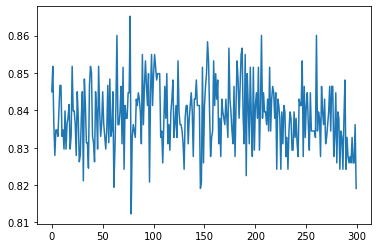

In [68]:
# K-Fold DecisionTree
model_kfdt = cross_val_score(tree.DecisionTreeClassifier(max_depth = 7), X, y, cv=300)
print('Maximum: ', model_kfdt.max())
print('Mean: ', model_kfdt.mean())

model_kfdt = pd.Series(model_kfdt)
model_kfdt.plot()

In [69]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2).fit(X_train, y_train)
model_knn_prediction = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, model_knn_prediction)

conf_knn = confusion_matrix(y_test, model_knn_prediction)
clf_report_knn = classification_report(y_test, model_knn_prediction)

print(f"Accuracy Score of KNN is : {accuracy_knn}")
print(f"Confusion Matrix : \n{conf_knn}")
print(f"Classification Report : \n{clf_report_knn}")

Accuracy Score of KNN is : 0.7876086066505936
Confusion Matrix : 
[[ 5762   181   563     0  1353]
 [  302   185   379     0   812]
 [  658   263   888     0  2142]
 [    3     1     1  6068    17]
 [  901   430  1330     2 21725]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      7859
           1       0.17      0.11      0.14      1678
           2       0.28      0.22      0.25      3951
           3       1.00      1.00      1.00      6090
           4       0.83      0.89      0.86     24388

    accuracy                           0.79     43966
   macro avg       0.61      0.59      0.60     43966
weighted avg       0.77      0.79      0.78     43966



In [70]:
kappa_knn = cohen_kappa_score(y_test, model_knn_prediction)
kappa_knn

0.6539957999352244

In [71]:
# Ada Boost
model_ada = AdaBoostClassifier(n_estimators = 1000).fit(X_train, y_train)
model_ada_prediction = model_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, model_ada_prediction)

conf_ada = confusion_matrix(y_test, model_ada_prediction)
clf_report_ada = classification_report(y_test, model_ada_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_ada}")
print(f"Confusion Matrix : \n{conf_ada}")
print(f"Classification Report : \n{clf_report_ada}")

Accuracy Score of Ada Boost Classifier is : 0.8357821953327571
Confusion Matrix : 
[[ 6574    30   578     0   677]
 [  214   102   379     0   983]
 [  636   146   879     0  2290]
 [    0     0     0  6090     0]
 [  594   102   591     0 23101]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      7859
           1       0.27      0.06      0.10      1678
           2       0.36      0.22      0.28      3951
           3       1.00      1.00      1.00      6090
           4       0.85      0.95      0.90     24388

    accuracy                           0.84     43966
   macro avg       0.66      0.61      0.62     43966
weighted avg       0.80      0.84      0.81     43966



In [72]:
kappa_ada = cohen_kappa_score(y_test, model_ada_prediction)
kappa_ada

0.7270463104892411

In [73]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
model_gb_prediction = model_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, model_gb_prediction)
conf_gb = confusion_matrix(y_test, model_gb_prediction)
clf_report_gb = classification_report(y_test, model_gb_prediction)

print(f"Accuracy Score of Gradient Boosting Classifier is : {accuracy_gb}")
print(f"Confusion Matrix : \n{conf_gb}")
print(f"Classification Report : \n{clf_report_gb}")

Accuracy Score of Gradient Boosting Classifier is : 0.848496565527908
Confusion Matrix : 
[[ 6569     7   614     0   669]
 [  171    36   454     0  1017]
 [  438    21  1207     0  2285]
 [    0     0     0  6090     0]
 [  295    13   677     0 23403]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7859
           1       0.47      0.02      0.04      1678
           2       0.41      0.31      0.35      3951
           3       1.00      1.00      1.00      6090
           4       0.85      0.96      0.90     24388

    accuracy                           0.85     43966
   macro avg       0.72      0.62      0.63     43966
weighted avg       0.82      0.85      0.83     43966



In [74]:
kappa_gb = cohen_kappa_score(y_test, model_gb_prediction)
kappa_gb

0.7470571315644801

In [75]:
# XgBoost Classifier
model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
model_xgb_prediction = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
conf_xgb = confusion_matrix(y_test, model_xgb_prediction)
clf_report_xgb = classification_report(y_test, model_xgb_prediction)

print(f"Accuracy Score of XgBoost Classifier is : {accuracy_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{clf_report_xgb}")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of XgBoost Classifier is : 0.8499749806668789
Confusion Matrix : 
[[ 6672    22   520     0   645]
 [  195    63   460     0   960]
 [  529    49  1231     0  2142]
 [    0     0     0  6090     0]
 [  335    47   692     0 23314]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      7859
           1       0.35      0.04      0.07      1678
           2       0.42      0.31      0.36      3951
           3       1.00      1.00      1.00      6090
           4       0.86      0.96      0.91     24388

    accuracy                           0.85     43966
   macro avg       0.70      0.63    

In [76]:
kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)
kappa_xgb

0.7507364121214731

In [77]:
# Cat Boost Classifier
model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
model_cat_prediction = model_cat.predict(X_test)

accuracy_cat = accuracy_score(y_test, model_cat_prediction)
conf_cat = confusion_matrix(y_test, model_cat_prediction)
clf_report_cat = classification_report(y_test, model_cat_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_cat}")
print(f"Confusion Matrix : \n{conf_cat}")
print(f"Classification Report : \n{clf_report_cat}")

Learning rate set to 0.5
0:	learn: 0.6766375	total: 264ms	remaining: 26.2s
1:	learn: 0.5439291	total: 362ms	remaining: 17.8s
2:	learn: 0.4857002	total: 452ms	remaining: 14.6s
3:	learn: 0.4509153	total: 545ms	remaining: 13.1s
4:	learn: 0.4289365	total: 649ms	remaining: 12.3s
5:	learn: 0.4165609	total: 757ms	remaining: 11.9s
6:	learn: 0.4092857	total: 858ms	remaining: 11.4s
7:	learn: 0.4015703	total: 952ms	remaining: 10.9s
8:	learn: 0.3966930	total: 1.04s	remaining: 10.5s
9:	learn: 0.3923257	total: 1.16s	remaining: 10.5s
10:	learn: 0.3879310	total: 1.28s	remaining: 10.4s
11:	learn: 0.3847699	total: 1.39s	remaining: 10.2s
12:	learn: 0.3829432	total: 1.53s	remaining: 10.2s
13:	learn: 0.3813565	total: 1.66s	remaining: 10.2s
14:	learn: 0.3781237	total: 1.82s	remaining: 10.3s
15:	learn: 0.3770750	total: 1.93s	remaining: 10.1s
16:	learn: 0.3758839	total: 2.01s	remaining: 9.83s
17:	learn: 0.3738543	total: 2.12s	remaining: 9.66s
18:	learn: 0.3731595	total: 2.21s	remaining: 9.41s
19:	learn: 0.371

In [78]:
kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)
kappa_cat

0.7498177671087365

In [79]:
# Extra Trees Classifier
model_etc = ExtraTreesClassifier().fit(X_train, y_train)
model_etc_prediction = model_etc.predict(X_test)

accuracy_etc = accuracy_score(y_test, model_etc_prediction)
conf_etc = confusion_matrix(y_test, model_etc_prediction)
clf_report_etc = classification_report(y_test, model_etc_prediction)

print(f"Accuracy Score of Extra Trees Classifier is : {accuracy_etc}")
print(f"Confusion Matrix : \n{conf_etc}")
print(f"Classification Report : \n{clf_report_etc}")

Accuracy Score of Extra Trees Classifier is : 0.8393076468179957
Confusion Matrix : 
[[ 6551   110   505     0   693]
 [  190   226   415     0   847]
 [  461   224  1204     0  2062]
 [    0     0     0  6090     0]
 [  398   271   889     0 22830]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7859
           1       0.27      0.13      0.18      1678
           2       0.40      0.30      0.35      3951
           3       1.00      1.00      1.00      6090
           4       0.86      0.94      0.90     24388

    accuracy                           0.84     43966
   macro avg       0.68      0.64      0.65     43966
weighted avg       0.82      0.84      0.83     43966



In [80]:
kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)
kappa_etc

0.7363764487583488

In [81]:
# LGBM Classifier
model_lgbm = LGBMClassifier(learning_rate = 1).fit(X_train, y_train)
model_lgbm_prediction = model_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, model_lgbm_prediction)
conf_lgbm = confusion_matrix(y_test, model_lgbm_prediction)
clf_report_lgbm = classification_report(y_test, model_lgbm_prediction)

print(f"Accuracy Score of LGBM Classifier is : {accuracy_lgbm}")
print(f"Confusion Matrix : \n{conf_lgbm}")
print(f"Classification Report : \n{clf_report_lgbm}")

Accuracy Score of LGBM Classifier is : 0.18250466269389984
Confusion Matrix : 
[[2778 1621 2412  223  825]
 [ 679  257  460   74  208]
 [1577  601 1260  148  365]
 [3708  384  709  657  632]
 [8748 4536 6276 1756 3072]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.16      0.35      0.22      7859
           1       0.03      0.15      0.06      1678
           2       0.11      0.32      0.17      3951
           3       0.23      0.11      0.15      6090
           4       0.60      0.13      0.21     24388

    accuracy                           0.18     43966
   macro avg       0.23      0.21      0.16     43966
weighted avg       0.41      0.18      0.19     43966



In [82]:
kappa_lgbm = cohen_kappa_score(y_test, model_lgbm_prediction)
kappa_lgbm

0.010741119631372031

In [83]:
# Models Comparison
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'K-Fold Decision Tree'],
    'Score' : [accuracy_lr, accuracy_knn, accuracy_dt, accuracy_rf, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_cat, 
              accuracy_etc, accuracy_lgbm, model_kfdt.mean()],
    'Kappa' : [kappa_lr, kappa_knn, kappa_dt, kappa_rf, kappa_ada, kappa_gb, kappa_xgb, kappa_cat, kappa_etc, kappa_lgbm, 
              model_kfdt.mean()]
})


models.sort_values(by = 'Kappa', ascending = False)

,Model,Score,Kappa
10,K-Fold Decision Tree,0.838550,0.838550
6,XgBoost,0.849975,0.750736
7,Cat Boost,0.848360,0.749818
3,Random Forest Classifier,0.847678,0.748827
5,Gradient Boosting Classifier,0.848497,0.747057
8,Extra Trees Classifier,0.839308,0.736376
4,Ada Boost Classifier,0.835782,0.727046
2,Decision Tree Classifier,0.805554,0.693834
0,Logistic Regression,0.813902,0.668414
1,KNN,0.787609,0.653996
